# Setup

Note: you might need to run `Pkg.instantiate()` to ensure that the `Manifest.toml` is up to date. This only needs to be done once.

In [1]:
import Pkg;
Pkg.activate(@__DIR__)
Pkg.status()

  Activating project at `/global/u1/b/blaschke/juliacon24-hpcworkshop/parts/distributed/explanation`


Status `/global/u1/b/blaschke/juliacon24-hpcworkshop/parts/distributed/explanation/Project.toml`
  [34f1f09b] ClusterManagers v0.4.6
  [d58978e5] Dagger v0.18.12
  [aaf54ef3] DistributedArrays v0.6.7
  [6f74fd91] NetworkInterfaceControllers v0.1.0
  [91a5bcdd] Plots v1.40.5


In [2]:
NWORKERS = 4

4

On your laptop you would do something like:

```julia
using Distributed
addprocs(4)
```

In [3]:
using Distributed, ClusterManagers

using NetworkInterfaceControllers, Sockets
interfaces = NetworkInterfaceControllers.get_interface_data(IPv4)

hsn0_public = filter(
    x->(x.name=="hsn0:chn" && x.version==:v4), interfaces
) |> only 
hsn0_public.ip

ip"128.55.84.171"

In [4]:
workers()

1-element Vector{Int64}:
 1

In [5]:
em = ElasticManager(addr=hsn0_public.ip, port=10001)  # or use: `addr=:auto`

println(em)

# launch workers
@async run(`srun -n $NWORKERS sh -c $(ClusterManagers.get_connect_cmd(em))`)

# wait for them to connect
while nworkers()<NWORKERS
    println("Waiting for workers, got: $(nworkers())")
    sleep(1)
end

ElasticManager:
  Active workers : []
  Number of workers to be added  : 0
  Terminated workers : []
  Worker connect command : 
    /global/common/software/nersc/n9/julia/1.9.4/bin/julia --project=/global/u1/b/blaschke/juliacon24-hpcworkshop/parts/distributed/explanation/Project.toml -e 'using ClusterManagers; ClusterManagers.elastic_worker("fFBNdLXOzFMcE7xa","128.55.84.171",10001)'
Waiting for workers, got: 1
Waiting for workers, got: 1
Waiting for workers, got: 1
Waiting for workers, got: 1
Waiting for workers, got: 1
Waiting for workers, got: 1
Waiting for workers, got: 1
Waiting for workers, got: 1


In [6]:
workers()

4-element Vector{Int64}:
 2
 3
 4
 5

In [7]:
[@fetchfrom p gethostname() for p in workers()]

4-element Vector{String}:
 "nid200348"
 "nid200345"
 "nid200349"
 "nid200344"

# Working with `Dagger.jl` on HPC

We now do the previous example but with `Dagger.jl` on top of `Distributed.jl`

## 1D Solver Example

Let's set up a basic example: 1D diffusion! First we need some parameters:

In [8]:
@everywhere begin
    D  = 1e-4
    ds = 1e-4
    dt = ds^2 / D / 8.2
    qx(ix, D, C, ds) = -D * (C[ix+1, 1] - C[ix, 1]) / ds
end

Instead of using `DArray`s from `DistributedArrays.jl` we now use `DArray`s from `Dagger.jl`

In [29]:
@everywhere using Distributed, Dagger

In `Dagger.jl` we can specify th underlying local blocks. Or you can use `AutoBlocks()` if you don't care.

In [41]:
C = zeros(Blocks(10, 1), 40, 1)

40x1 DMatrix{Float64} with 4x1 partitions of size 10x1:
~0% completed
 ...
 ...
 ...
 ...
 ...
 ...
 ...
 ...
 ...
 ...
 ...
 ...
 ...
 ⋮
 ...
 ...
 ...
 ...
 ...
 ...
 ...
 ...
 ...
 ...
 ...
 ...

`Dagger.jl` is non-blocking, so above you returned before `C` was filled. If you wait a little (or use `fetch(C)`) then it'll be ready:

In [42]:
fetch(C)

40x1 DMatrix{Float64} with 4x1 partitions of size 10x1:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

Unlike with `DistributedArrays.jl`, in `Dagger.jl` we have can use the global address space to also set items in a vector/array:

In [43]:
C[20, 1] = 1/ds

10000.0

In [44]:
C2 = similar(C)

40x1 DMatrix{Float64} with 4x1 partitions of size 10x1:
~0% completed
 ...
 ...
 ...
 ...
 ...
 ...
 ...
 ...
 ...
 ...
 ...
 ...
 ...
 ⋮
 ...
 ...
 ...
 ...
 ...
 ...
 ...
 ...
 ...
 ...
 ...
 ...

In [45]:
fetch(C2)

40x1 DMatrix{Float64} with 4x1 partitions of size 10x1:
   6.95209e-310
   6.95209e-310
   6.95209e-310
   6.95209e-310
   6.95209e-310
   6.95209e-310
   6.95209e-310
   6.95209e-310
   6.95209e-310
   6.95209e-310
   1.66036e-319
   6.94618e-310
   1.01516e-316
   ⋮
  20.8662
   0.0
 262.133
 288.385
 313.307
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0

In `Dagger.jl` we can use write a diffusion step that operates only on the "local" part of the array. I.e. operting only on `C.subdomains[myid() - 1]`.

In [15]:
@everywhere function step_diffusion_local!(C2, C)
    proc = myid() - 1
    idx = C.subdomains[proc].indexes[1] # working in 1D
    
    for i in idx
        # absorbing boundary conditions (lo, hi are always set to zero)
        if i==1 || i==size(C, 1)
            continue
        end
        C2[i] = C[i] - dt * (qx(i, D, C, ds) - qx(i-1, D, C, ds)) / ds
    end
end

## `Dagger.jl` scopes

in Dagger we don't have control _where_ things run by default

In [16]:
d1 = Dagger.@spawn myid()
d2 = Dagger.@spawn myid()

DTask (running)

In [17]:
fetch(d1)

4

In [18]:
fetch(d2)

3

For this we have `Dagger.scope`:

In [19]:
d = Dagger.@spawn scope=Dagger.scope(worker=2) myid()

DTask (running)

In [20]:
fetch(d)

2

So if we run our local diffusion setp on worker 3 onlym then you see that we're filling in only part of `C2`:

In [21]:
C2 = similar(C)
d = Dagger.@spawn scope=Dagger.scope(worker=3) step_diffusion_local!(C2, C)

DTask (running)

In [22]:
fetch(C2[10:30, 1])

21x1 DMatrix{Float64} with 3x1 partitions of size 10x1:
 6.94666e-310
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 2.0e-323
 4.0e-323
 1.5e-323
 1.6e-322
 2.30252e-314
 4.94e-322
 4.94e-321
 1.235e-321
 1.0e-322
 5.0e-324

## Putting it all together

So now we have everything to solve our diffusion equation: for every timestep we start the local diffusion step (`step_diffusion_local!`) on every worker. We use `Dagger.scope` to ensure that each worker runs on each subdomain _once_ only.

In [27]:
function step_diffusion(C)
    C2 = similar(C)
    fill!(C2, 0)
    
    dtasks = Dagger.DTask[]
    for w in workers()
        push!(
            dtasks,
            Dagger.@spawn scope=Dagger.scope(worker=w) step_diffusion_local!(C2, C)
        )
    end
    
    # wait for workers
    [fetch(d) for d in dtasks]
    C2
end

step_diffusion (generic function with 1 method)

Warm up:

In [46]:
sols = [Array(step_diffusion(C))]

1-element Vector{Matrix{Float64}}:
 [0.0; 0.0; … ; 0.0; 0.0;;]

Again, we run 100 timesteps, and save every 10th. **Warning:** This is super wasteful, don't do this in production

In [47]:
for i in 1:100
    C = step_diffusion(C)
    # Save timesteps.
    if i%10 == 0
        push!(sols, Array(C))
    end
end

In [48]:
using Plots

And we see a nice diffusion process in 1D:

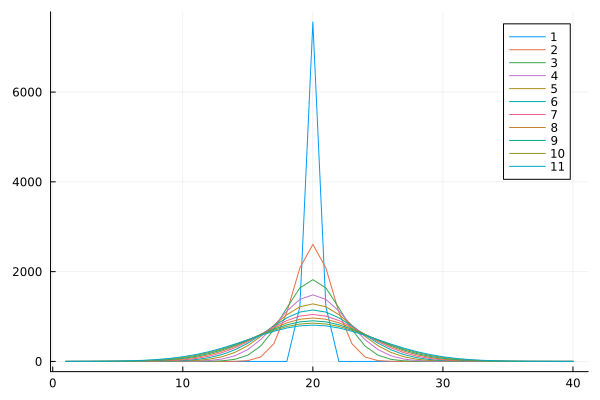

In [49]:
plot()
for (i,c) in enumerate(sols)
    plot!(c, label=i)
end
plot!()